In [4]:
import sys
sys.path.append("../")
import numpy as np
import numpy.linalg as LA
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from numpy.lib.function_base import cov
from sys import argv
from libs.functions import sigmoid, g_lo, g_up, nearPD, sample_wise_vec_mat_vec, deriv_sigmoid,\
                           sample_wise_outer_product, deriv_sigmoid, init_discriminator
from libs.create import create_out_cov, create_norm_data
from libs.utils import tqdm_slack, slack_massage
import matplotlib.pyplot as plt

n = 1000
m = 3*n
eps = 0.2
data_dim = 2
mu = 0
mu_out = 3
par_mu = np.full(data_dim, mu)
# par_sd = np.identity(data_dim)
out_mu = np.array([1,-1])*3

par_reg1=0.005
exper_iter = 3
optim_iter = 2000
L = 1
learn_par = 0.01
dicay_par = 0.3

In [10]:
res_cov = [0 for _ in range(exper_iter)]
res_par = [0 for _ in range(exper_iter)]
res_par_cov=[]
def discriminator(x, beta):
    size, data_dim = x.shape[0], x.shape[-1]
    beta = beta.reshape([data_dim,data_dim])
    value = sample_wise_vec_mat_vec(beta,x)
    return value

par_sd = cov=np.array([
    [3,1],
    [1,1]
])
out_cov=np.array([
    [3,-1.5],
    [-1.5,1]
])
slack_massage("exper start!")
for exp_index in range(exper_iter):
    slack_massage("%d/%d"%(exp_index+1,exper_iter))
    res_par_cov.append(par_sd)
    data = create_norm_data(n, eps, par_mu, par_sd, out_mu, out_cov)
    cov_hist = []
    par_hist = []
    # 平均は次元ごとにロバスト、分散はロバストでない
    B=LA.cholesky(np.cov(data, rowvar = False))
    alpha = [np.full(data_dim, par_mu), B]
    z = np.random.multivariate_normal(mean=alpha[0], cov=B@B.T, size = m)


    size_par = data_dim**2
    par = (B@B.T).reshape(size_par)
    # par = np.random.normal(loc = 0, scale = 0.1, size = size_par)
    bias = np.array(np.mean(discriminator(z, par[0:size_par]) ))[np.newaxis]
    par = np.concatenate([par, bias], axis = 0) #(d**2 +1)
    cov_hist.append(alpha[1]@alpha[1].T)
    par_hist.append(par)
    for j in tqdm_slack(optim_iter):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1]@alpha[1].T , size = m)
        zzT = sample_wise_outer_product(z,z)
        xxT = sample_wise_outer_product(data, data)
        A=np.zeros([data_dim, data_dim, data_dim, data_dim])
        A_bias_col = np.zeros([data_dim,data_dim])
        A_b = np.zeros([data_dim,data_dim])
        A_bias_row = np.zeros([data_dim, data_dim])
        l=0
        while l<L:
            t0_z = discriminator(z, par[:-1]) - par[-1] #shape (m,)
            t0_data = discriminator(data, par[:-1]) - par[-1] # (n,)

            for i in range(data_dim):
                for k in range(data_dim):
                    A[i][k] = -1/10*( np.mean(z[:,i][:,np.newaxis, np.newaxis]*z[:,k][:,np.newaxis,np.newaxis]*zzT, axis=0)\
                                    + np.mean(data[:,i][:,np.newaxis, np.newaxis]*data[:,k][:,np.newaxis, np.newaxis]*xxT, axis = 0))             
                A_bias_col[i] = 1/10*(np.mean(z[:,i][:,np.newaxis]*z, axis=0) +np.mean(data[:,i][:,np.newaxis]*data, axis=0))
                A_b[i] = -(np.mean(((deriv_sigmoid(t0_z)+t0_z/10)*z[:,i])[:,np.newaxis]*z, axis=0)\
                            -np.mean(((deriv_sigmoid(t0_data)-t0_data/10)*data[:,i])[:,np.newaxis]*data,axis=0)) 
                A_bias_row[i] = 1/10*(np.mean(z[:,i, np.newaxis]*z , axis=0)  +np.mean(data[:,i, np.newaxis]*data , axis=0))
            bias_bias = -0.2
            b_bias = ( np.mean(deriv_sigmoid(t0_z) + t0_z/10, axis=0) -np.mean(deriv_sigmoid(t0_data - t0_data/10),axis=0)) 


            A_bias_col_reshaped = A_bias_col.reshape(data_dim**2, 1)    
            A_bias_row_reshaped = A_bias_row.reshape(1,data_dim**2)    
            A_b_reshaped = A_b.reshape(data_dim**2)

            A_reshaped = A.T.reshape(data_dim,data_dim**2,data_dim).T.reshape(data_dim**2,data_dim**2)
            A_concated = np.concatenate([A_reshaped, A_bias_col_reshaped], axis=1)
            A_bias_row_concated = np.concatenate([A_bias_row_reshaped, np.array(bias_bias)[np.newaxis, np.newaxis]], axis=1)
            A_ = np.concatenate([A_concated,A_bias_row_concated], axis=0)
            b = np.concatenate([A_b_reshaped, b_bias[np.newaxis]], axis = 0)
            
            par = LA.lstsq(A_,b)[0]
            l+= 1


        z = np.random.multivariate_normal(mean=alpha[0], cov=np.eye(data_dim) , size = m)
        alpha_m = alpha[0]; alpha_v = alpha[1]
        ABZ = (z@par[:-1].reshape(data_dim, data_dim))@(alpha_v+alpha_v.T)
        sigma_grad = sample_wise_outer_product(ABZ, z) #(m, d, d)
        sig_ = deriv_sigmoid(discriminator(z@alpha_v, par[:-1]) - par[-1])[:,np.newaxis] #(m,)
        tmp_alpha_v = alpha_v - learn_par/(j+1)**dicay_par * np.mean(sigma_grad*sig_[:,:,np.newaxis], axis = 0)
        alpha[1] = tmp_alpha_v

        cov_hist.append(alpha[1]@alpha[1].T)
        par_hist.append(par)
    res_cov[exp_index] = cov_hist
    res_par[exp_index] = par_hist
slack_massage("exper finish !")

100%|██████████| 2000/2000 [00:11<00:00, 177.75it/s]


In [11]:

def plot():
    cov = np.array(res_cov)
    cov_end = []


    plt.subplots()
    for i in range(exper_iter):
        loss_cov = LA.norm(cov[i] - par_sd, ord = 2, axis = (1,2))
        plt.plot(loss_cov)
        cov_end.append(loss_cov[-1])
    print("cov  ave : %.5f" %np.mean(cov_end))
    print("cov  std : %.5f" %np.std(cov_end))



cov  ave : 1.56451
cov  std : 0.06309


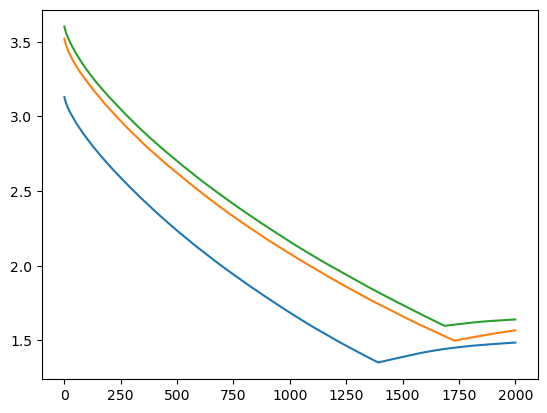

In [12]:
plot()

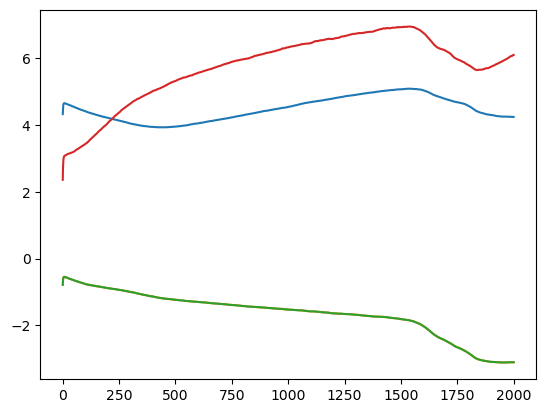

In [15]:
plt.plot(np.array(res_par)[0,:,:-1])

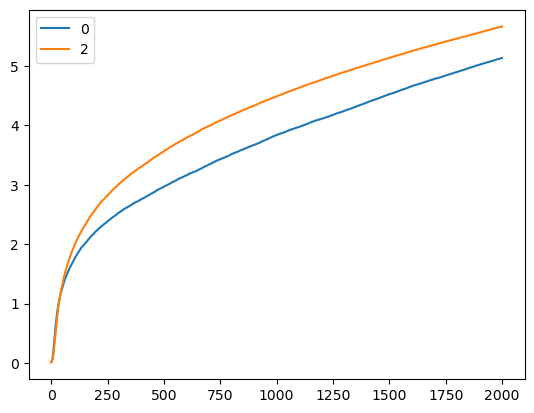

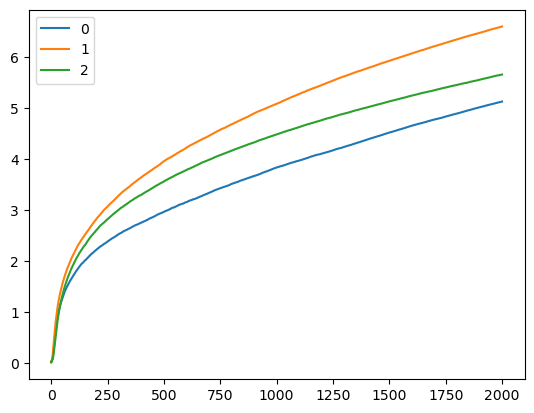

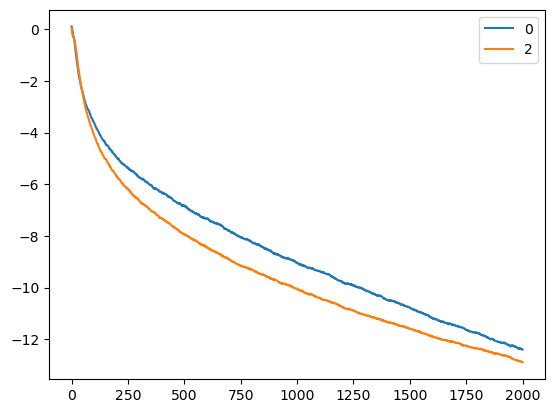

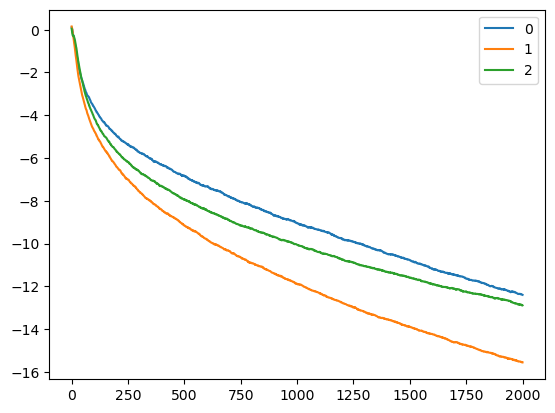

In [8]:
par = np.array(res_par)
cov = np.array(res_cov)
bad = [0,2]
plt.subplots()
for i in bad:
    norm = LA.norm(par[i,:,:-1], axis=1)
    plt.plot(norm, label=str(i))
    plt.legend()

plt.subplots()
for i in range(exper_iter):
    norm = LA.norm(par[i,:,:-1], axis=1)
    plt.plot(norm, label=str(i))
    plt.legend()

plt.subplots()
for i in bad:
    plt.plot(par[i,:,-1], label=str(i))
    plt.legend()

plt.subplots()
for i in range(exper_iter):
    plt.plot(par[i,:,-1], label=str(i))
    plt.legend()

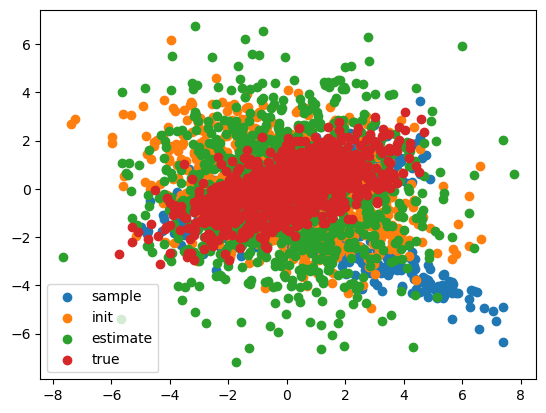

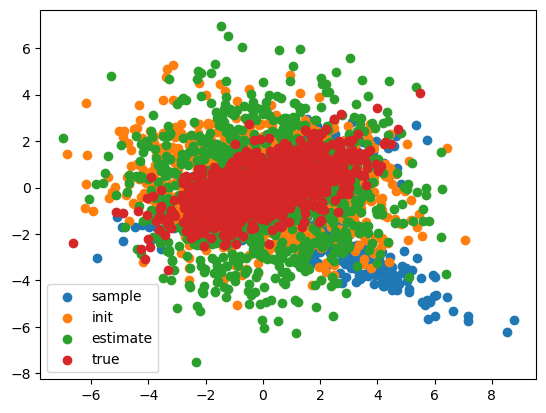

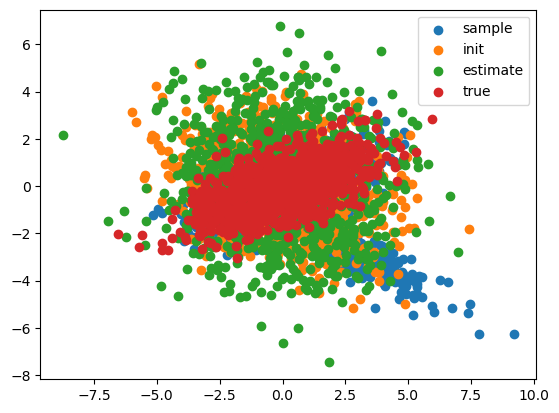

In [9]:
for j in range(exper_iter):
    plt.subplots()
    cov = np.array(res_cov)
    data = create_norm_data(1000, eps, par_mu, par_sd, out_mu, out_cov)
    plt.scatter(data[:,0], data[:,1], label="sample")

    data = np.random.multivariate_normal(np.zeros(2), cov[j,0], size=1000)
    plt.scatter(data[:,0], data[:,1], label="init")

    data= np.random.multivariate_normal(np.zeros(2), cov[j,-1], size=1000)
    plt.scatter(data[:,0], data[:,1], label="estimate")
    data = np.random.multivariate_normal(np.zeros(2), par_sd, size=1000)
    plt.scatter(data[:,0], data[:,1], label="true")
    plt.legend()


In [ ]:
import seaborn as sns
a = np.array(res_par)[0,0,:-1].reshape(2,2)
sns.heatmap(a)
a = np.array(res_par)[0,-1,:-1].reshape(2,2)
sns.heatmap(a)

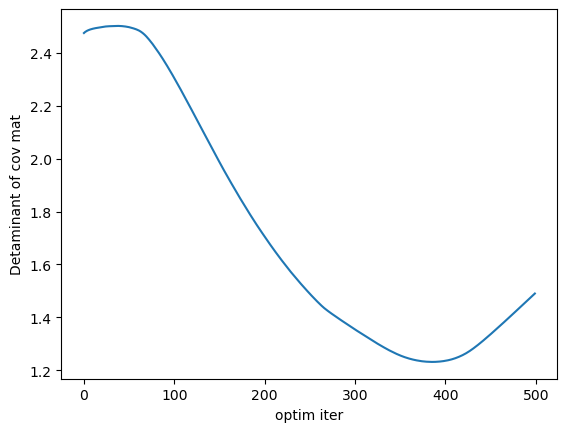

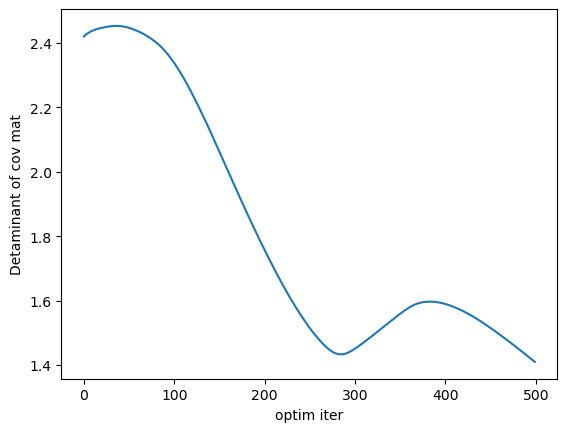

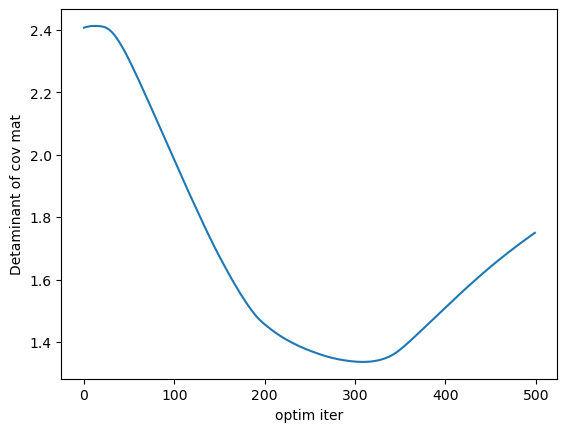

In [18]:
for i in range(exper_iter):
    plt.subplots()
    plt.plot(np.array(detaminant)[optim_iter*i:optim_iter*(i+1)])   
    plt.xlabel("optim iter")
    plt.ylabel("Detaminant of cov mat")

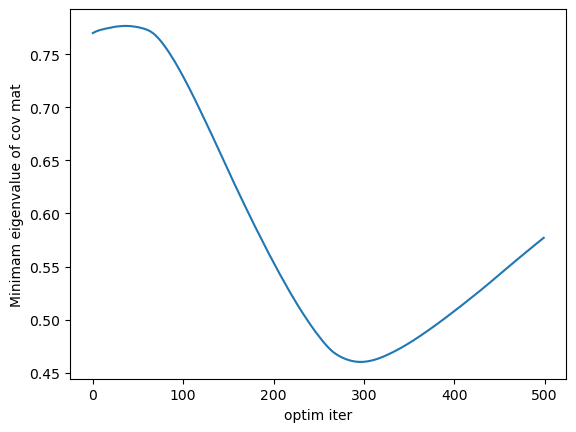

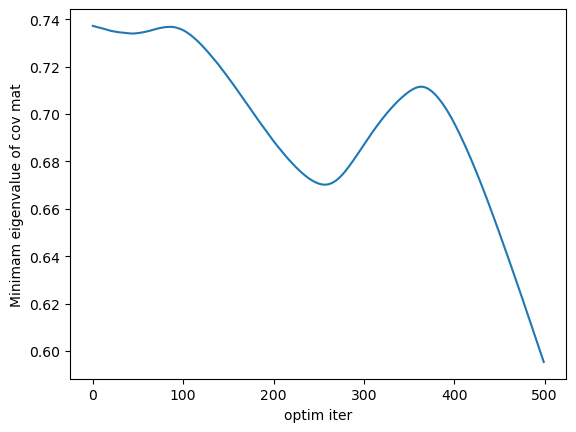

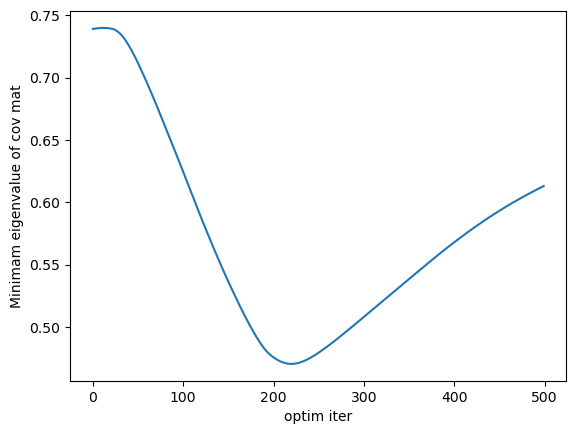

In [19]:
for i in range(exper_iter):
    plt.subplots()
    plt.plot(np.array(is_pdm)[optim_iter*i:optim_iter*(i+1)])
    plt.xlabel("optim iter")
    plt.ylabel("Minimam eigenvalue of cov mat")

In [96]:
cov[4,-1]

array([[5.81213859, 0.14435315],
       [0.14435315, 3.70004348]])

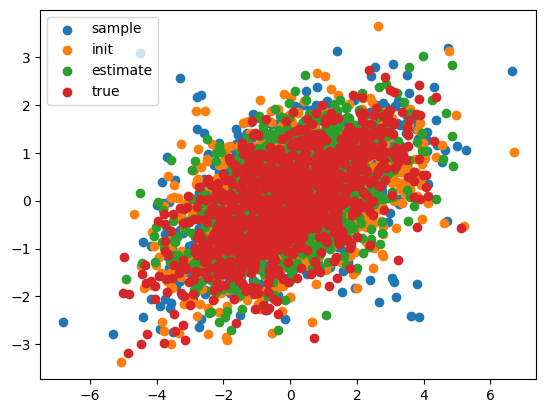

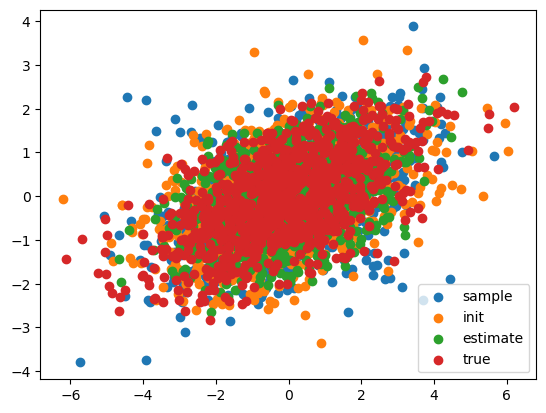

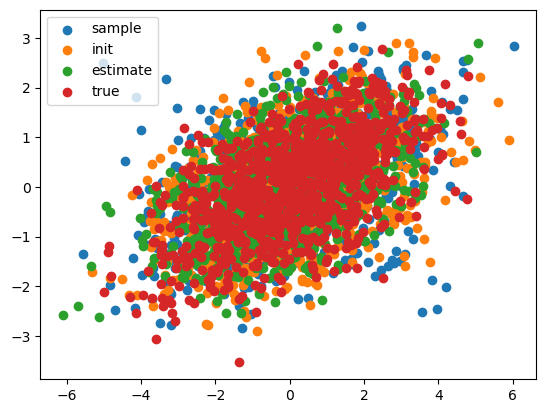

In [20]:
for j in range(exper_iter):
    plt.subplots()
    cov = np.array(res_cov)
    data = create_norm_data(1000, eps, par_mu, par_sd, out_mu, out_cov)
    plt.scatter(data[:,0], data[:,1], label="sample")

    data = np.random.multivariate_normal(np.zeros(2), cov[j,0], size=1000)
    plt.scatter(data[:,0], data[:,1], label="init")

    data= np.random.multivariate_normal(np.zeros(2), cov[j,-1], size=1000)
    plt.scatter(data[:,0], data[:,1], label="estimate")
    data = np.random.multivariate_normal(np.zeros(2), par_sd, size=1000)
    plt.scatter(data[:,0], data[:,1], label="true")
    plt.legend()
